<a href="https://colab.research.google.com/github/egonik-unlp/dolar_historico/blob/main/notebooks/ambito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parseador de datos de Dolar Historico de Ámbito Financiero

## Preparamos el entorno de colab para correr selenium

In [5]:
%%capture
%load_ext google.colab.data_table

!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
mpl.rcParams.update({'font.size':16}) 
import matplotlib.ticker as mtick
import time
import pandas as pd
from selenium.webdriver.common.keys import Keys


chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)


In [6]:
def get_data(URL:str, XPATH:str, XPATH_CLICK:str, XPATH_TABLE:str)->str:
    wd.get(URL)
    field=wd.find_element_by_xpath(XPATH)
    field.click()
    for _ in range(12):
        field.send_keys(Keys.BACKSPACE)
    field.send_keys("03-01-1989")
    field.send_keys(Keys.ENTER)
    field2=wd.find_element_by_xpath(XPATH_CLICK)
    field2.click()
    time.sleep(5)
    table_field=wd.find_element_by_xpath(XPATH_TABLE)
    return table_field.get_attribute('innerHTML')
def parser(table_element:str)-> dict:
    soup=BeautifulSoup(table_element, 'lxml')
    # table = soup.find_all('table')[0] # Grab the first table
    table=soup
    for rows in soup.find_all('tr'):
        finder = lambda x: rows.find_all(x)
        if finder('th'):
            headers=[nodo.get_text() for nodo in finder('th')]
            data = {header:[] for header in headers }
        else: 
            row=[nodo.get_text() for nodo in finder('td')]
            for i,v in enumerate(data.values()):
                v.append(row[i])
    return data

def make_dataframe(data:dict)-> pd.DataFrame:
    dataframe=pd.DataFrame(data=data).replace(r",",'.', regex=True)
    dataframe.iloc[:,1]=dataframe.iloc[:,1].astype(float)
    dataframe.iloc[:,2]=dataframe.iloc[:,2].astype(float)
    dataframe.iloc[:,0]=pd.to_datetime(dataframe.iloc[:,0], dayfirst=True)
    dataframe.index=dataframe["Fecha"]
    dataframe.drop(columns='Fecha', inplace=True)
    return dataframe

def main():

    XPATH="/html/body/main/div[6]/div/div/div[1]/input"
    XPATH_TABLE='/html/body/main/div[6]/div/div/table'
    XPATH_CLICK="/html/body/main/div[6]/div/div/button"
    URL="https://www.ambito.com/contenidos/dolar-informal-historico.html"
    raw_data = get_data(URL,XPATH,XPATH_CLICK,XPATH_TABLE)
    data = parser(raw_data)
    try:
        dataframe = make_dataframe(data)
    except ValueError:
        print('fallo, retorno data cruda')
        return data
    return dataframe


In [7]:
df = main()
df

,Compra,Venta
Fecha,,
2021-05-28,152.00,157.00
2021-05-27,152.00,157.00
2021-05-26,150.00,155.00
2021-05-24,148.00,153.00
2021-05-21,148.00,153.00
...,...,...
2002-01-17,1.92,1.97
2002-01-16,1.83,1.87
2002-01-15,1.90,1.95


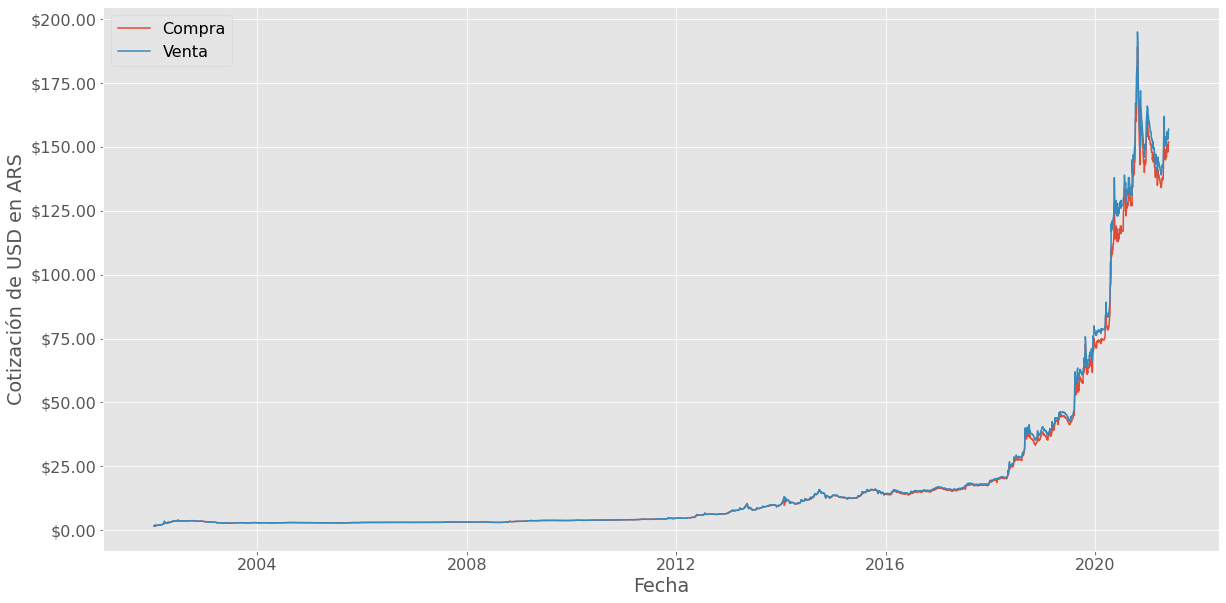

In [21]:
fig, ax = plt.subplots(1,1 ,figsize=(20,10))

ax.plot(df.index, df.Compra, label= 'Compra')
ax.plot(df.index, df.Venta, label= 'Venta')
ax.set_ylabel('Cotización de USD en ARS')
ax.set_xlabel('Fecha')
fmt= '${x:.2f}'
tick = mtick.StrMethodFormatter(fmt)
ax.get_yaxis().set_major_formatter(tick)
plt.legend()
plt.show()


## Desde 2020

In [ ]:

ultimos = df[df.index > '2020']
fig, ax = plt.subplots(1,1 ,figsize=(20,10))

ax.plot(ultimos.index, ultimos.Compra, label= 'Compra')
ax.plot(ultimos.index, ultimos.Venta, label= 'Venta')
ax.set_ylabel('Cotización de USD en ARS')
ax.set_xlabel('Fecha')
fmt='${x:.2f}'
tick = mtick.StrMethodFormatter(fmt)
ax.get_yaxis().set_major_formatter(tick)
plt.legend()
plt.show()

## Solo 2021

In [ ]:

ultimo_mes = df[df.index > '2021']
fig, ax = plt.subplots(1,1 ,figsize=(20,10))

ax.plot(ultimo_mes.index, ultimo_mes.Compra, label= 'Compra')
ax.plot(ultimo_mes.index, ultimo_mes.Venta, label= 'Venta')
ax.set_ylabel('Cotización de USD en ARS')
ax.set_xlabel('Fecha')
fmt='${x:.2f}'
tick = mtick.StrMethodFormatter(fmt)
ax.get_yaxis().set_major_formatter(tick)
plt.legend()
plt.show()

In [ ]:
df.to_excel('datos_ambito.xls')